In [1]:
from google.colab import drive
drive.mount('/content/drive')

## Modify this...
! cp -Rfp "/content/drive/MyDrive/_colab_code/112B 深度學習與Python實作/data" .

Mounted at /content/drive


Code from: PyTorch深度學習入門與應用：必備實作知識與工具一本就學會
ISBN：9786263332591

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import torchvision
from torchvision import datasets, models
from torchvision import transforms
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(1234)  # Set the seed for PyTorch random number generator to ensure reproducibility.
np.random.seed(1234)     # Set the seed for NumPy random number generator to ensure reproducibility.
random.seed(1234)        # Set the seed for Python's built-in random number generator to ensure reproducibility.

In [5]:
# Define a sequence of transformations to be applied to training data

train_transforms=transforms.Compose([

    # Randomly crop the image to size 224x224
    transforms.RandomResizedCrop(224),

    # Randomly flip the image horizontally
    transforms.RandomHorizontalFlip(),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize the image with mean [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225]
    transforms.Normalize(
        [0.485,0.456,0.406],
        [0.229,0.224,0.225]
    )
])

In [6]:
val_transforms=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485,0.456,0.406],
        [0.229,0.224,0.225]
    )
])

In [7]:
train_dataset=datasets.ImageFolder(
    root="data/bees_ants/train",
    transform=train_transforms
)

In [8]:
val_dataset=datasets.ImageFolder(
    root="data/bees_ants/val",
    transform=val_transforms

)

In [9]:
train_loader=torch.utils.data.DataLoader(  # Create a DataLoader object for training data
    train_dataset,  # Use the train_dataset as the source of data
    batch_size=4,   # Set the batch size to 4, meaning each iteration will process 4 samples
    shuffle=True,   # Shuffle the data at the beginning of each epoch to introduce randomness
    num_workers=4   # Use 4 worker processes to load data in parallel, which can speed up the process
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
val_loader=torch.utils.data.DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

In [11]:
model=models.resnet18(weights='ResNet18_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [12]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [13]:
model.fc=nn.Linear(model.fc.in_features,2)
print(model.fc)

Linear(in_features=512, out_features=2, bias=True)


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model=model.to(device)
print(device)

cpu


In [15]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [16]:
from torch.optim.lr_scheduler import StepLR
exp_lr_scheduler=StepLR(optimizer,step_size=7,gamma=0.1)

In [17]:
epochs = 5  # Number of epochs for training

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    losses = 0.0  # Initialize the total loss
    corrects = 0  # Initialize the number of correct predictions

    # Iterate over the training data batches
    for inputs, labels in train_loader:
        inputs = inputs.to(device)  # Move inputs to the appropriate device (e.g., GPU)
        labels = labels.to(device)  # Move labels to the appropriate device
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the parameters

        _, preds = torch.max(outputs, 1)  # Get the predicted labels
        losses += loss.item() / inputs.size(0)  # Accumulate the loss
        corrects += torch.sum(preds == labels.data) / inputs.size(0)  # Accumulate the number of correct predictions

    exp_lr_scheduler.step()  # Adjust the learning rate
    train_loss = losses / len(train_loader)  # Calculate average training loss
    train_acc = corrects / len(train_loader)  # Calculate training accuracy

    model.eval()  # Set the model to evaluation mode
    losses = 0.0  # Initialize the total loss for validation
    corrects = 0  # Initialize the number of correct predictions for validation

    # Iterate over the validation data batches
    for inputs, labels in val_loader:
        inputs = inputs.to(device)  # Move inputs to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        _, preds = torch.max(outputs, 1)  # Get the predicted labels
        losses += loss.item() / inputs.size(0)  # Accumulate the loss
        corrects += torch.sum(preds == labels.data) / inputs.size(0)  # Accumulate the number of correct predictions

    val_loss = losses / len(val_loader)  # Calculate average validation loss
    val_acc = corrects.double() / len(val_loader)  # Calculate validation accuracy

    # Print the epoch number, training loss, training accuracy, validation loss, and validation accuracy
    print(f"epoch: {epoch}, Train loss: {train_loss:.4f}, acc:{train_acc:.4f}, \
    Val loss: {val_loss:.4f}, acc:{val_acc:.4f}")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 0, Train loss: 0.1538, acc:0.7008,     Val loss: 0.0549, acc:0.9295
epoch: 1, Train loss: 0.1362, acc:0.8033,     Val loss: 0.0999, acc:0.7756
epoch: 2, Train loss: 0.1038, acc:0.8238,     Val loss: 0.0583, acc:0.9231
epoch: 3, Train loss: 0.1280, acc:0.7869,     Val loss: 0.0864, acc:0.8654
epoch: 4, Train loss: 0.1535, acc:0.7746,     Val loss: 0.0839, acc:0.9231


In [18]:
inputs,classes=next(iter(val_loader))  # 取得一批圖像
class_name=val_dataset.classes

outputs=model(inputs.to(device))  # 預測輸出
_,preds=torch.max(outputs,1)
title=[class_name[x] for x in preds]
print(inputs.shape)
print(title)

torch.Size([4, 3, 224, 224])
['bees', 'bees', 'ants', 'bees']


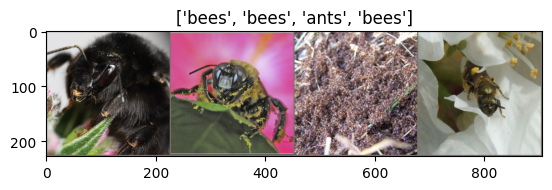

In [19]:
import matplotlib.pyplot as plt

out=torchvision.utils.make_grid(inputs)  # 顯示圖像
out=out.numpy().transpose((1,2,0))
mean=np.array([0.485,0.456,0.406])
std=np.array([0.229,0.224,0.225])
out=std*out+mean
out=np.clip(out,0,1)

plt.imshow(out)
if title is not None:
    plt.title(title)

plt.show()

In [20]:
torch.save(model.state_dict(),"bee.pt")